# LDA Plotting using only the Validation Data

In [25]:
from sklearn.utils import resample

def resample_to_equal_class_sizes(X,y):
    df = pd.DataFrame(X)
    df['group'] = [int(i) for i in y]
    groups = []
    for v in set(df['group']):
        groups.append(df[df['group'] == v])
           
    max_length = max([len(group) for group in groups])
    print("Maximum class size is %s" %max_length)
    
    final_groups = []
    for group in groups:
        if len(group) < max_length:
            print("Class %s size is %s. Resampling with replacement to %s" %(max(group['group']),len(group), max_length))
            final_groups.append(resample(group, replace=True, n_samples=max_length))
        else:
            print("Class %s size has max class size (%s)." %(max(group['group']), max_length))
            final_groups.append(group)
    df = pd.concat(final_groups)
    return df.drop('group', axis=1).values, df['group'].values
    

#print(X_train_std.shape)
#print(y_train_group_park.shape)
#xr, yr = resample_to_equal_class_sizes(X_train_std, y_train_group_park)
#print(xr.shape, yr.shape)


In [26]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

In [27]:
# Read in the data
import pandas as pd

raw_data = pd.read_excel('data/Validation.xlsx')

# remove unneeded subject ID column
data = raw_data.drop(['Subject', 'GUID'], axis=1)

In [28]:
# split the X and y data
X = data.drop('GroupID', axis=1).values
y = data['GroupID'].values

In [29]:
# standardize the data by removing the mean (making it 0) and scaling to unit variance
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(X)
X = std_scale.transform(X)


In [30]:
# Train the LDA transformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [31]:
# Transform train and test data with lda model
X = lda.transform(X)


In [32]:
print('explained variance ratio (LDA): %s'
      % str(lda.explained_variance_ratio_))


explained variance ratio (LDA): [0.6128827  0.27781136 0.10930594]


<IPython.core.display.Javascript object>


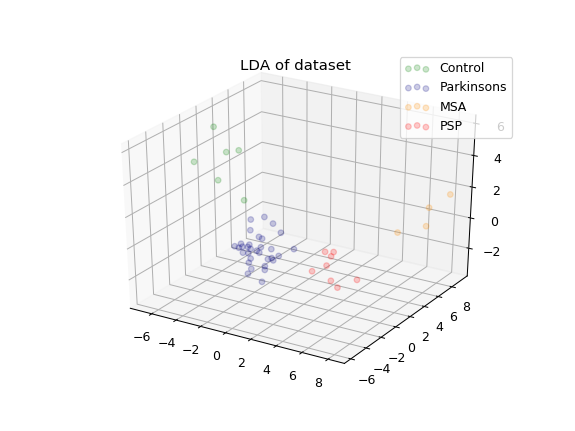

In [33]:
# Plot the LDA-transformed training data in 3d
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['green', 'navy', 'darkorange', 'red']
target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X[y == i, 0], X[y == i, 1], X[y == i, 2], alpha=.2, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()


In [34]:
X.shape

(50, 3)

In [32]:
clf = svm_grid_search(X_train_lda, X_test_lda, y_train, y_test, cv=5)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

1.000 (+/-0.000) for {'C': 0.001, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 0.01, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 0.1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1000, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'ke

C:\Users\jtbricker\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
